# Load in Data
Using the MNE data set, slightly modified to pretend that the button presses were in response to the stimuli (in this example the subject went 16/304 on responses to stimuli so they weren't paying much attention :) ), a model for how to use this tool to preprocess and do preliminary analyses on a complex task including stimuli and a response is presented

In [1]:
from MEEGbuddy import MEEGbuddy
'''Please read import errors and warnings and if there
   are packages that are useful for your analyses you can'''
from pandas import read_csv, DataFrame
from shutil import copyfile
import mne, os
import os.path as op
import numpy as np

subject = 'sample'

task = 'AudioVis'

stimuli = {'Cue': ['STI 014', -0.5, 1.5]}
response = ['STI 006', -1.5, 0.5]
baseline = ['STI 014', -1.1, -0.1]

sample_mne_data_path = mne.datasets.sample.data_path(path=op.join(os.getcwd(), 'data'))
behavior = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis.csv')
fdata = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis-raw.fif')
fdata2 = op.join(sample_mne_data_path, 'MEG', 'sample', 'sample_audvis_raw.fif')
stim_key = {1: 'Left Auditory', 2: 'Left Visual', 3: 'Right Auditory', 4: 'Right Visual',
            5: 'Smiley'}

fs_subjects_dir = op.join(sample_mne_data_path, 'subjects')
bemf = op.join(fs_subjects_dir, '%s/bem/sample-5120-5120-5120-bem-sol.fif' % subject)
srcf = op.join(fs_subjects_dir, '%s/src/sample-ico-5-src.fif' % subject)
transf = op.join(sample_mne_data_path, 'MEG', subject, 'sample_audvis_raw-trans.fif')

behavior_description = {'Trial': 'The order of the stimulus presentations',
                        'Stimulus Type': 'Whether an audio, visual or smiley ' + 
                                         'stimulus was shown and to which side',
                        'Response Time': 'The amount of time it took the subject' + 
                                          'to respond'}

if not op.isfile(behavior) or not op.isfile(fdata):
    raw = mne.io.Raw(fdata2, preload=True)
    events = mne.find_events(raw, stim_channel='STI 014')
    events_button = mne.find_events(raw, stim_channel='STI 006')
    for event in (events_button[:, 0] - raw.first_samp):
        raw._data[raw.info['ch_names'].index('STI 014'), event: event+10] = 0 #take responses out of this channel
    events_no_button = events[events[:, 2] != 32]
    events_button = events[events[:, 2] == 32]
    response_times = []  
    '''pretend buttons are in response to last stimulus shown 
    i.e. the subject was told to respond to all stimuli but only did so for a few 
    (not realistic but just to model for other tasks)'''
    for i,(t,_,event_id) in enumerate(events[:-1]):
        if events[i+1,2] == 32:
            response_times.append((events[i+1,0]-events[i,0]) / raw.info['sfreq'])
        elif events[i,2] != 32:
            response_times.append(np.nan)
    behavior_data = {'Trial': np.arange(len(events_no_button)),
                     'Stimulus Type': np.array([stim_key[e] for e in events_no_button[:, 2]]),
                     'Response Time': response_times}
    df = DataFrame(behavior_data)
    df.to_csv(behavior, index=False)
    raw.save(fdata,overwrite=True)


if not op.isfile(bemf):
    conductivity = (0.3, 0.006, 0.3)  # for three layers
    model = mne.make_bem_model(subject='sample', ico=4,
                               conductivity=conductivity,
                               subjects_dir=fs_subjects_dir)
    bem = mne.make_bem_solution(model)
    mne.write_bem_solution(bemf, bem)


if not op.isfile(op.join(fs_subjects_dir, srcf)):
    src = mne.setup_source_space('sample', spacing='oct6',
                                 subjects_dir=fs_subjects_dir, add_dist=False)
    src.save(srcf, overwrite=True)


df = read_csv(behavior)
no_response = [i for i, rt in enumerate(df['Response Time']) if np.isnan(rt)]
exclude_response = [0, len(df)-1]
print('Loading into MEEGbuddy ' + subject)
data = MEEGbuddy(subject=subject, session=None, fdata=fdata, behavior=behavior,
                 baseline=baseline, stimuli=stimuli, meg=True, eeg=True,
                 response=response, no_response=no_response, task=task,
                 exclude_response=exclude_response, 
                 fs_subjects_dir=fs_subjects_dir, bemf=bemf, srcf=srcf, 
                 transf=transf, subjects_dir=op.join(os.getcwd(), 'data'))


Loading into MEEGbuddy sample


# Reload Data
If you have already run the first cell, you can just run this cell to load in the MEEGbuddy data object

In [ ]:
from MEEGbuddy import loadMEEGbuddy
import os.path as op
import os

subject = 'sample'

data = loadMEEGbuddy(op.join(os.getcwd(), 'data'), subject, eeg=True, meg=True, task='AudioVis')

# Save to BIDS
Using the package mne-bids, we can save data in bids format by providing the bids directory and some neccesary files so that it can be uploaded to a data repository such as OpenNeuro for data sharing and reproducability.

In [ ]:
data.save2BIDS('data_BIDS')

# Preprocessing

## Filter Raw Data
Remove DC offset and very low frequency components for visualization.
MEEGbuddy works on the basic system of naming data with keywords,
in this case no keyword loads the raw data file and then keyword_out
saves the data elsewhere (it's impossible to overwrite the original).
My suggestion is to save out many copies at first when you're designing
your analysis but then to save out just the crutial ones when you're 
analyzing many subjects to save space.
Usually people don't analyze this low so we can just apply this to the raw
data without using a keyword argument to save a new branch as a copy.
Note: if you are getting weird results with the ICA in MEG it is probably because
the cHPI coil signal has not been filtered out. This is at approximately 150 Hz
so a 130 or lower lowpass is usually needed.

In [2]:
data.filterRaw(keyword_out='Preprocessed', maxwell=True, overwrite=True)
data.filterRaw(keyword_in='Preprocessed', l_freq=0.1, overwrite=True) # if no keyword_out, keyword_in gets used

/autofs/space/karima_001/users/alex/MEEGbuddy/MEEGbuddyDemo/data/MNE-sample-data/MEG/sample/sample_audvis-raw.fif
Saving raw Preprocessed
Preprocessed raw data loaded.
Saving raw Preprocessed


## Mark Bads

Use the automatic bad channel marker algorithm

In [3]:
data.autoMarkBads(keyword_in='Preprocessed', overwrite=True) 

Preprocessed raw data loaded.
grad
mag
eeg
EEG 053 removed: flat
Saving raw Preprocessed


## Plot Raw
QC that auto mark bads did a good enough job, we don't want really bad
components in the data because they could swamp our ICA. It's also a huge
pain to select out bad channels for many subjects, hence this very simple
approach of autoMarkBads that could potentially eliminate this step. When you do
QC it is easier to have the evoked as well which are plotted first. This
allows you to scan the averaged data so that you don't have to look through all
the data at this step.
(NB: autoMarkBads is not very sensitive which is a good thing because if there is 
usable data we want to let autoreject try to save it by rejecting and interpolating epochs that need it)

In [11]:
event = 'Cue'
condition = 'Stimulus Type'
data.makeEpochs(keyword_in='Preprocessed', keyword_out='Vis', overwrite=True) 
data.filterEpochs(event, keyword_in='Vis', h_freq=40, l_freq=None, overwrite=True) 
data.plotEvoked(event, condition=condition, values=['all'], keyword='Vis',
                show=True, detrend=1, downsample=False) 
data.plotRaw(keyword_in='Preprocessed', overwrite=True) 

Preprocessed raw data loaded.
Baseline events found: 304
Saving epochs for Baseline
Baseline epochs loaded
Cue events found: 304
Saving epochs for Cue
Cue epochs loaded
Response events found: 16
Saving epochs for Response
Cue epochs loaded
Saving epochs for Cue
Cue epochs loaded
Preprocessed raw data loaded.
Saving raw Preprocessed


## Interpolate TMS Artifact (only for TMS, not relevant to this sample dataset)

In [13]:
raw_interp, _ = data.plotInterpolateArtifact(event, keyword='Preprocessed',
                                             mode='spline', npoint_art=5, 
                                             offset=1, tmin=-0.1, tmax=0.1,
                                             ylim=[-1e-4,1e-4])
data.applyInterpolation(raw_interp, keyword_out='TMS', overwrite=True)

Preprocessed raw data loaded.
Saving raw TMS


## Make and Visualize Epochs for Conditions (Optional)
We already supplied all the information needed to make epochs.

We compare conditions (Left/Right Auditory/Visual)
    that can be provided by values but if value argument
    is not passed they are selected by default as all the unique
    conditions. As you can see from the plot there is a ton of eyeblink
    contamination that ICA will hopefully remove and if not
    those epochs will be rejected (by autoreject).
    
It may be helpful to do this now, especially for testing your pipeline, or you could just wait until the raw data is preprocessed by ICA and make into epochs and those epochs are preprocessed with autoreject. 

In [14]:
event = 'Cue'
condition = 'Stimulus Type'
data.makeEpochs(keyword_in='Preprocessed', keyword_out='Vis', overwrite=True)
data.filterEpochs(event, h_freq=40, l_freq=None, keyword_in='Vis',overwrite=True)
data.plotEvoked(event, condition=condition, keyword='Vis', show=True, 
                detrend=1, downsample=False)

Preprocessed raw data loaded.
Baseline events found: 304
Saving epochs for Baseline
Baseline epochs loaded
Cue events found: 304
Saving epochs for Cue
Cue epochs loaded
Response events found: 16
Saving epochs for Response


## Precompute ICA

Depending on the number of subjects, this is a great time to take a break, or leave for a couple hours.

In [7]:
data.findICA(keyword_in='Preprocessed', keyword_out='ICA', 
             n_components=50, overwrite_ica=True, overwrite=True)

Preprocessed raw data loaded.
Using EOG 061 as eogs
Using  as ecgs
grad
Saving evoked for ica_EOG 061 grad_ICA
Components removed for EOG 061: 1
Saving ICA grad_ICA
mag
Saving evoked for ica_EOG 061 mag_ICA
Components removed for EOG 061: 1
Saving ICA mag_ICA
eeg
Saving evoked for ica_EOG 061 eeg_ICA
Components removed for EOG 061: 0
Saving ICA eeg_ICA
Saving raw ICA


Quality check ICA (will need to do multiple times if the components are hand-selected) (click on the component name to see topo)

    I removed components 1 (blink), 8 (heartbeat), 36 (heartbeat) for magnetometers,
    1 (sacade), 2 (heartbeat), 21 (heartbeat) for gradiometers and 0 (blink), 1 (whole head),
    7 (heartbeat), 14 (muscle), 19 (muscle), 22 (muscle), 28-32 (muscle), 34 (muscle), 36 (muscle),
    39 (muscle), 42-43 (muscle) and 45 (muscle) for eeg. These are hard without HEOG and ECG 
    accessory electrodes. There are three things that show up at first; 
    a evoked time course of each of the ICA source components for each auxillary channel,
    a topo of all the components and a time course of the ICA components raw.plot()-style
    where the components can be selected out. 
    
    The way I choose has three parts: 
    
    First, I look at the topological distributions, distributions that are front heavy 
    and look like eyes are probably blinks, distributions that have a left-right polarization
    (left red, right blue or vice versa) are probably saccades (although these are sometimes
    tricky because they have a tilt to them) and distributions that are back-heavy (occipital)
    are probably heartbeat (eeg 7 is a good example). I also see global components which 
    look like a mostly all red or all blue topo, these are usually the first one or two 
    and in my experience tend to be blinks or mixes of the artifacts. In general there are
    often one major component for each source (blinks, saccades, heartbeat) and sometimes
    a few what I like to think of as harmonics. It would be a lot easier with another EOG 
    and an ECG to pick these components out.
    
    Then, I look at the time course on the larger plot with all the ICA components
    and each smaller eog/ecg epochs plot to confirm that the topo intuition matches
    the actual time course. I also sometimes add components with abnormal topos by
    clicking on the ICA component time course plot. My general outlook on this is
    that if you saw that your results had the topo-distribution of a components,
    if you would think "I think that's eyeblink, I better go back and redo ICA,"
    I would just save yourself the trouble and remove it now. Just because the component
    is time-locked, however, I don't always remove it if it has a non-typical topo
    because in my opinion that is most likely data (these are usually lower contribution
    components anyway).
    
    Finally, I look at the effect on the eog and ecg epochs. Optimally the lines
    would be very flat due to noise cancelling on average. Depending on how 
    agressive you want to be, you can remove  anything that has any time-locked 
    components which will probably include some brain signal (the blinks originated
    from motor commands in the brain after all) but my general opinion is that this 
    is pretty safe to tend towards aggressively removing components.
    
    These aren't the only correct answers and by changing around components more
    biological artifact could potentially be removed but ICA doesn't always capture
    everything which often means the artifact is not very present and thus not something
    to worry about. The data should definitely be usable from here. 

## QC/Choose ICA Components to Remove
The algorithm is really not good enough to call it QC'ing, you really need to do this by hand at this point

If after the first try of selecting components, the signal with ICA subtracted still doesn't look clean, then rerun the cell and try again.

In [8]:
data.plotICA(keyword_in='Preprocessed', keyword_out='ICA')

Preprocessed raw data loaded.
Using EOG 061 as eogs
Using  as ecgs
ICA loaded.
ica_EOG 061 evoked loaded for grad_ICA
ica_EOG 061 evoked loaded for grad_ICA
Saving ICA grad_ICA
ICA loaded.
ica_EOG 061 evoked loaded for mag_ICA
ica_EOG 061 evoked loaded for mag_ICA
Saving ICA mag_ICA
ICA loaded.
ica_EOG 061 evoked loaded for eeg_ICA
ica_EOG 061 evoked loaded for eeg_ICA
Saving ICA eeg_ICA
Saving raw ICA
Enter to continue, n to go back


## ICA on Epochs (Only TMS-EEG)
You would usually only want to use this if you have to because you can't make artifact epochs (blink, saccade) but if you are downsampling then you need to run ICA on epochs otherwise your event markers would be thrown off

In [9]:
event = 'Cue' 
data.makeEpochs(keyword_in='TMS', overwrite=True)
data.findICA(event=event, keyword_in='TMS', keyword_out='TMS_ICA',
             n_components=50, overwrite=True, overwrite_ica=True)

Cue epochs loaded for TMS
Using EOG 061 as eogs
Using  as ecgs
grad
Saving ICA grad_TMS_ICA
mag
Saving ICA mag_TMS_ICA
eeg
Saving ICA eeg_TMS_ICA
Saving epochs for Cue TMS_ICA
Cue epochs loaded for TMS
Using EOG 061 as eogs
Using  as ecgs
ICA loaded.
Saving ICA grad_TMS_ICA
ICA loaded.
Saving ICA mag_TMS_ICA
ICA loaded.
Saving ICA eeg_TMS_ICA
Saving epochs for Cue TMS_ICA
Enter to continue, n to go back


In [ ]:
event = 'Cue'
data.plotICA(event=event, keyword_in='TMS', keyword_out='TMS_ICA') # I selected out grad: 0 (heartbeat), 1 (blink), 15 (heartbeat);
    ''' mag: 0 (whole head), 2 (blink), 7 (heatbeat); eeg: 0 (blink), 2 (muscle), 5 (muscle), 8 (muscle), 10-14 (muscle), 16 (heartbeat),
        18-20 (muscle), 22 (muscle), 24 (muscle), 27 (muscle), 29-30 (muscle), 32-33 (muscle), 35 (muscle), 47-48 (muscle)
        Note this is for the bad channels I selected in epochs bad channel selection above, if you didn't select the same channels, your
        results may be different (bad channels MEG 2443, EEG 053)'''

## Make Epochs with ICA Raw
This overwrites the previous epochs used for visualization
    using keyword_out as a input variable we could save out a
    copy but we don't really need the last epochs made using the
    preprocessed but not ICA-applied data. As you might notice,
    I don't tend to save all the intermediate epochs without overwriting,
    I generally just save out the epochs once autoreject has been applied
    because you can just make them from raw data very quickly if you need them.

In [11]:
data.makeEpochs(keyword_in='ICA', overwrite=True)

ICA raw data loaded.
Baseline events found: 304
Saving epochs for Baseline
Baseline epochs loaded
Cue events found: 304
Saving epochs for Cue
Cue epochs loaded
Response events found: 16
Saving epochs for Response


# Visualize Epochs Post-ICA

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.filterEpochs(event, h_freq=40, l_freq=None, keyword_in='ICA',
                  keyword_out='Vis', overwrite=True)
data.plotEvoked(event, condition=condition, keyword='Vis',
                show=True, detrend=1, downsample=False)
data.remove(event, keyword='Vis') #Save disk space

## Mark Any More Bad Channels
The data looks much better, but sometimes few channels look out of wack in the
    evoked plots (you can click on the plots for the channel names) so we can mark those
    as bad before autoreject. I like the image plots for this because you can really pick out
    channels that are bad by eye much easier. My general approach on this is anything
    that could dramatically throw off your data should be removed because you would not want
    to take the chance that autoreject would miss it but anything that contains enough clean epochs
    (>50% perhaps) that it could add to your data could be left to autoreject. In this case, 
    I think all of the channels are good enough to see if autoreject can repair them.

In [12]:
data.plotRaw(keyword_in='ICA', overwrite=True)

ICA raw data loaded.
Saving raw ICA


## Autoreject Trial Rejection and Trial-by-Trial Channel Rejection

Run autoreject on epochs: this will take a long time but you get even clearer data
    
       It is okay to lowpass filter epochs because the filter has good spatial
       resolution, but highpassing would require too long of a filter so we do that
       earlier. On principle you should keep the most of your data you can keep until 
       you have to remove it, which is why this is here.
       
PS This takes two hours or so per subject for the three events in this case

In [4]:
data.makeEpochs(keyword_in='ICA', overwrite=True)
for event in data.getEvents(): #this includes 'Baseline' and 'Response' 
    #data.filterEpochs(event, keyword_in='ICA', h_freq=150, l_freq=None, overwrite=True)  (Optional)
    data.markAutoReject(event, keyword_in='ICA', keyword_out='Autoreject',
                        overwrite=True)

Cue epochs loaded
Saving epochs for Cue
Autoreject already calculated, use 'overwrite=True' to recalculate.
Response epochs loaded
Saving epochs for Response
Autoreject already calculated, use 'overwrite=True' to recalculate.
Baseline epochs loaded
Saving epochs for Baseline
Autoreject already calculated, use 'overwrite=True' to recalculate.


## QC of Final Evoked Data
I like the image plots because you can really see there is
    a similar pattern for both congruent and incongruent trials,
    it is just much more pronounced for incongruent trials, which
    you can't see as well from the evoked plots (the top two).

Response epochs loaded for autoreject
Saving epochs for Response ar_filtered
Response epochs loaded for ar_filtered
Subsampling 68/75 RewardType High.
Subsampling 68/68 RewardType Low.


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


Response epochs loaded for autoreject
Response epochs loaded


/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/autofs/space/karima_001/users/alex/software/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend

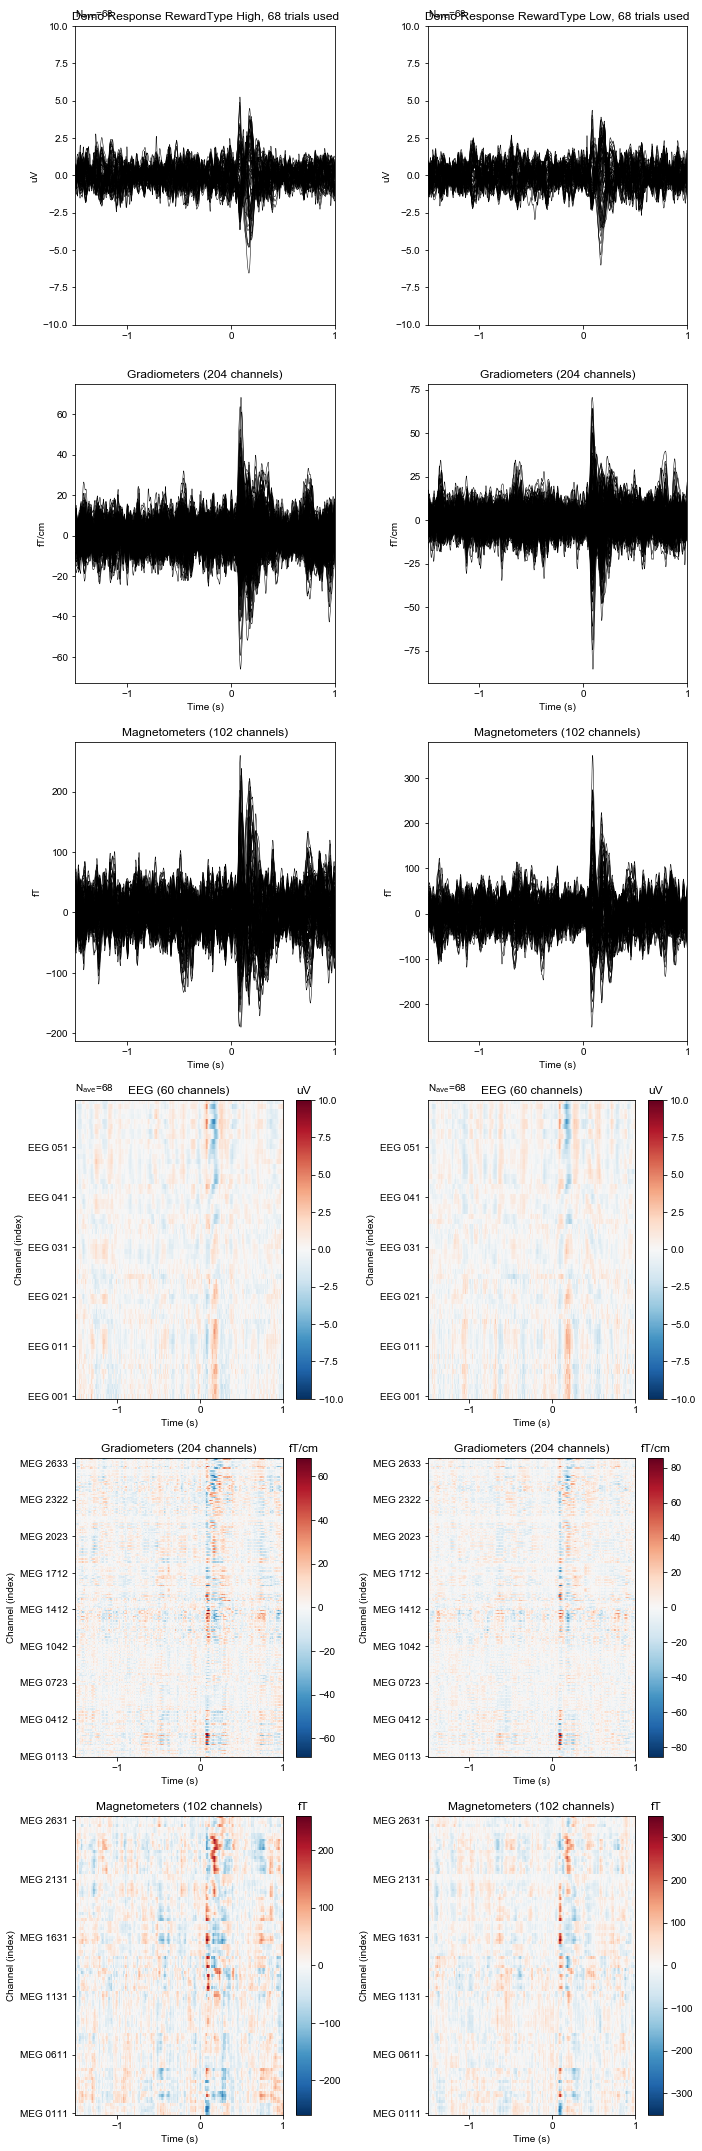

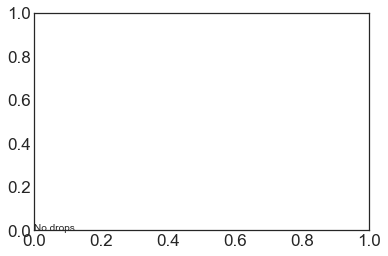

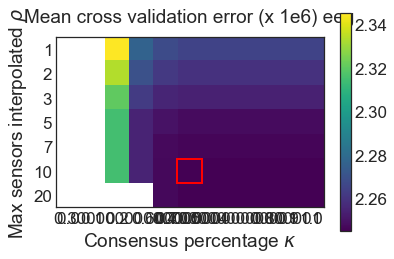

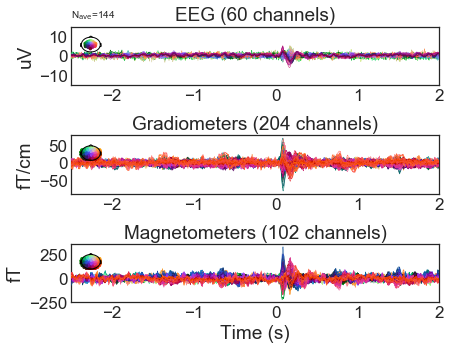

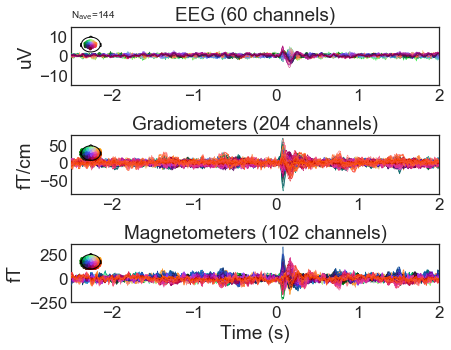

In [6]:
event = 'Cue'
condition = 'Stimulus Type'
data.filterEpochs(event, h_freq=40, l_freq=None, keyword_in='Autoreject',
                  keyword_out='Autoreject_Filtered')
data.filterEpochs('Baseline', h_freq=40, l_freq=None, keyword_in='Autoreject',
                  keyword_out='Autoreject_Filtered')
data.plotEvoked(event,condition=condition,ylim={'eeg': [-20, 20]},
                keyword='Autoreject_Filtered', downsample=False )
data.plotAutoReject(event, keyword_in='Pre-Autoreject',
                    keyword_out='Autoreject')

## Transform to Source Space
To transform to source space we need to average epochs, so we'll pick response and rewardtype to average by
Note: if you want to do source space separately for MEG and EEG, the way that is supported is to make separate MEEGbuddy objects for both modalities:

    raw = Raw(fname, preload=True)
    raw_meg = raw.copy().pick_types(meg=True, eeg=False, eog=True, ecg=True, stim=True)
    raw_meg.save(fname_meg)
    raw_eeg = raw.copy().pick_types(meg=False,eeg=True,eog=True,ecg=True,stim=True)
    raw_eeg.save(fname_eeg)

In [10]:
event = 'Cue'
condition = 'Stimulus Type'
data.epochs2source(event, condition, keyword_in='Autoreject',
                   overwrite=True)

Response epochs loaded for autoreject
Baseline epochs loaded for autoreject
Making forward model...
Making inverse for High...
Saving inverse for Response RewardType High
Applying inverse on baseline for High...
Saving source for Baseline RewardType High
Applying inverse for High
Saving source for Response RewardType High
Making inverse for Low...
Saving inverse for Response RewardType Low
Applying inverse on baseline for Low...
Saving source for Baseline RewardType Low
Applying inverse for Low
Saving source for Response RewardType Low


## Time Frequency Decomposition

This is a very memory intensive analysis: it was 100 GB just for this one sample subject with ~300 epochs. This is because the data for the epochs (n_epochs by n_channels by n_times) is the number of frequency steps (in this example and by default 32) times as large (n_steps by n_epochs by n_channels by n_times). A way to get around the intensive memory issues would be to write only one condition-value pair to disk at a time (~10 GB) and then plot/run analyses, delete and then repeat.

NB: Default power type is non-phase-locked (npl) but total (t) and phase-locked (pl) are also possible. 

Note also: Gain normalization or baseline substraction can be done to normalize the data, it is recommended to use keyword_out = 'Gain_Normalized' or 'Baseline_Subtracted' etc.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.makeWavelets(event, condition, keyword_in='Autoreject',
                  keyword_out='Power',power_type='pl',
                  overwrite=True)
data.makeWavelets(event, condition, keyword_in='Autoreject',
                  keyword_out='Power',
                  power_type='npl',overwrite=True)

## Clean up (optional)
Remove epochs that can be generated from the raw data in a couple seconds of computation.

In [ ]:
for event in data.getEvents():
    data.remove(event, keyword='Vis')
    data.remove(event, keyword='Pre-Autoreject')

# Visualizations

## Plot Source Space
Nota bene: while this is running, it's okay to put other windows in front of the mayavi window but if you minize the mayavi window the images will be of your desktop :) 

PS: You're going to want to leave this to run overnight

In [ ]:
%matplotlib inline

event = 'Cue'
condition = 'Stimulus Type'
data.plotSourceSpace('Cue','Stimulus Type',keyword='Autoreject',tmin=-0.1,tmax=0.3,show=True)

## Topoplot

In [1]:
event = 'Cue'
condition = 'Stimulus Type'
data.plotTopo(event, condition=condition, keyword='Autoreject_Filtered',
              show=True, detrend=1, downsample=False)

Cue epochs loaded for Autoreject_Filtered


## Channel Plot

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.channelPlot(event, condition, keyword='Autoreject_Filtered')

## TFR Plot

NB: I was able to plot all the values at because I am working on a computer with 64 GB of RAM and 64 GB more of swap and left this overnight. If you're working on a system with less RAM, you would probably want to use values=['Left Auditory','Right Auditory'] etc.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.plotTFR(event, condition, keyword='Autoreject', power_type='pl')
data.plotTFR(event, condition, keyword='Autoreject', power_type='npl')
data.plotTFR(event, condition, keyword='Autoreject', bands=None, power_type='pl')
data.plotTFR(event, condition, keyword='Autoreject', bands=None, power_type='npl')

## Multitaper Spectrogram (for determining sleep)
As to be expected, the partipant in this example was awake and so their spectrogram shows no signs of sleep as described at sleepeeg.org (thanks to Mike Prerau!). If they were asleep you could use the GUI to drag boxes around the areas of wake and sleep which would then be saved out in the behavior (under "State" as default as in condition='State',values=['Sleep','Wake','Neither'] but these labels can be changedt too)

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.psdMultitaper(keyword='Preprocessed', ch='EEG 059') #typically Oz is used and I think this is Oz in this dataset

## Control Variables
Most will usually not be that useful but some are really good out of the box!

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.plotControlVariables()

# Analyses

Note: Be careful in analyses to specify a sensible bl_tmin and bl_tmax for the stimulus channel that you are interested. This is most often a problem for response which could triggered by a different event marker. In that case, you would need the response epochs to extend far enough back to be before the stimulus presentation and would use bl_tmin and bl_tmax based on those. This is relevant for PCI and Wavelet Connectivity.

## Cluster Permutation Test

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'

data.CPT(event,condition,keyword_in='Autoreject_Filtered',keyword_out='CPT',overwrite=True)
data.plotCPT(event,condition,keyword_in='Autoreject_Filtered',cpt_p=0.001,keyword_out='CPT')

## TFR CPT

Note: we can do this for epochs but once we estimate source space, we can no longer do the necessary permutations across epochs so this particular analysis can only be done in sensor space (see Source Permutation and Source Correlation below for options on how to do similar analyses on source estimates)

NB: This method only makes sense if you did not gain normalize the tfr. Gain normalization can be useful for visualization and determining which frequencies are highly upregulated, similar to plotting using a logarithmic scale.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'

for value in data._default_values(condition): # pass one at at time to save on memory
    data.CPT(event, condition, values=[value], keyword_in='Autoreject',
             keyword_out='TFR_CPT', power_type='npl', tfr=True,
             tfr_keyword='Autoreject', overwrite=True)
    data.CPTByBand(event, condition, values=[value], keyword_in='Autoreject',
                   keyword_out='TFR_CPT', power_type='npl',
                   tfr_keyword='Autoreject', overwrite=True)

data.plotCPT(event, condition, keyword_in='Autoreject', tfr=True,
             power_type='npl', keyword_out='CPT')
data.plotCPTByBand(event, condition, keyword_in='Autoreject', tfr=True,
                   power_type='npl', keyword_out='CPT')

## Wavelet Connectivity

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.waveletConnectivity(event, condition, keyword_in='Autoreject',
                         keyword_out='WC', downsample=False)

## Lempel-Ziv Compression for Computing PCI
See https://github.com/noreun/pypci for the source code and 

A. G. Casali, O. Gosseries, M. Rosanova, M. Boly, S. Sarasso, K. R. Casali, S. Casarotto,
M.-A. Bruno, S. Laureys, G. Tononi, M. Massimini, A theoretically based index of consciousness
independent of sensory processing and behavior. Sci. Transl. Med. 5, 198ra105 (2013).

for the theory of this method. Note: this is mostly used for TMS-EEG but is being used by me to analyze psychophysical task data

Note: shared baseline=True uses all epochs for baseline which shouldn't be used for awake/asleep TMS because asleep baseline EEG will be very different but for this dataset, especially with the small and unbalanced number of stimulus presentations with very similar baselines, this should be a prudent approach to average more epochs and thus reduce noise in the baseline bootstrap thresholding step.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
alpha = 0.05
    
data.noreunPhi(event=event, condition=condition, keyword_in='Autoreject',
               npoint_art=0, shared_baseline=True, downsample=False,
               recalculate_baseline=False, tmin=0.0, tmax=0.5,
               alpha=alpha, keyword_out='PCI_alpha_%s' %(alpha))

data.plotNoreunPCI(event, condition, keyword='PCI_alpha_%s' % alpha,
                   shared_baseline=True, show=True)

### Parallelized Version of LZ
This can take a while if you are running more than one subject/event/condition so I have included how to parallelize the process using joblib

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
alpha = 0.05

def noreunpassf(data,**kwargs):
    print(data.subject)
    if (data._has_epochs(kwargs['event'], kwargs['keyword_in']) and 
        all([(data._has_source(kwargs['event'],kwargs['condition'], value,
                               keyword=kwargs['keyword_in']) 
              for value in data._default_values(kwargs['condition']))])):
        data.noreunPhi(**kwargs)
    else:
        print(data.subject + ' epochs/sources not found')
    
with Parallel(n_jobs=n_jobs) as parallel:
    parallel(delayed(noreunpassf)(data, event=event, condition=condition, values=None,
                                  keyword_in='Autoreject', npoint_art=0, shared_baseline=True,
                                  downsample=True, recalculate_baseline=False,
                                  alpha=alpha,keyword_out='alpha%s' % alpha) for data in tqdm(data_struct))

## Souce Bootstrap

Randomize all the epochs (of interest) and transform to source space as evoked or as time-frequency evoked potentials to create a distribution of what would be expected if the effect had no effect (was completely random). This can be used in the next two sections to either look for correlations with a condition or two look for differences between two values.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.sourceBootstrap(event, condition=condition, keyword_in='Autoreject', keyword_out='SB',
                     values=['Left Auditory', 'Right Auditory'], 
                     bands={'alpha': (8, 15),'beta': (15, 35)},
                     itc=False, overwrite=True) # Inter-trial coherence optional (all of these take up a lot of space)

### Source Permutation
This saves the clusters (in the form source index, time index) and their p-values as well as a source estimate with values 1/p for all significant clusters. This source estimate can then be visualized with plotSourceSpace or in MMVT (recommended, see mmvt.org / https://github.com/pelednoam/mmvt).

This method will save out one source estimate for each value; 1/p for the p values of the source estimate for that value compared to the bootstrap distribution. In this particular example, there will be one source estimate of where the left auditory stimulus is different from a distribution of both and one where the right auditory stimulus is different from a distribution of both. In a more appropriately designed analyses, there would be a case-control where the control would not be of interest (but might be nice to have as a sanity check!) and should yield little to no significant differences where the case would be of interest. For instance, congruent v incongruent trials in the multi-source interference task.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
data.sourcePermutation(event,condition,keyword_in='SB', keyword_out='SP',
                       values=['Left Auditory', 'Right Auditory'])

#### Source Plot Visualization

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
for value in ['Left Auditory', 'Right Auditory']:
    for band in [None, 'alpha', 'beta']:
        this_value = value + '_permutation' if band is None else value + '_power_permutation_%s' % band
        data.plotSourceSpace('Cue', 'Stimulus Type', values=[this_value],
                             keyword='SP', tmin=-0.1, tmax=0.3,
                             use_saved_stc=True, show=True)

### Source Correlation
This is the method used to generate the first figure on the home page. In this method, one continuous variable has it's relationship to the epochs shuffled many times to create a null distribution of correlations of the continuous variable to the epochs. The observed correlation is then compared to the null to find significant correlations. For example, I am analyzing a learning task where latent learning state can be estimated for each trial, thus latent learning state can be correlated with activity or power of a particular frequency.

In [ ]:
event = 'Cue'
condition = 'Stimulus Type'
# if we had a continuous variable like latent learning state etc.
# we could do this but for this sample dataset, none of the 
# variables make sense to use this analysis on
data.sourcePermutation(event, condition, keyword_in='SB',
                       keyword_out='SC', correlation=True)